<a href="https://colab.research.google.com/github/singhtejn/Stock_AI_ML/blob/main/DRL_for_Stock_Trading_SuperTrendAI%26AMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Packages

!pip install ta
!pip install optuna
!pip install yfinance
!pip install tensorboardX
!pip install stable.baselines3
!pip install stable-baselines3[extra]
!pip install --upgrade stable-baselines3
!pip3 install torch torchvision torchaudio

# Install TA-Lib

# Install dependencies
!apt-get install -y build-essential
!apt-get install -y wget
!apt-get install -y libtool
!apt-get install -y automake
# Download the TA-Lib source code
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# Extract the tarball
!tar -xvzf ta-lib-0.4.0-src.tar.gz
# Change directory to the extracted folder
%cd ta-lib
# Configure and build TA-Lib
!./configure --prefix=/usr
!make
!make install
# Install the Python wrapper for TA-Lib
!pip install ta-lib
# Verify the installation
# import talib
# print(talib.get_functions())


# Import Libraries

#import ta
import os
import gym
import json
import plotly
import optuna
import random
import logging
import warnings
import talib
warnings.filterwarnings("ignore")
import yfinance
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()

from gym import spaces
from gym.utils import seeding
from tensorboardX import SummaryWriter
from stable_baselines3 import A2C, PPO, DDPG
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.policies import ActorCriticPolicy #MlpPolicy for A2C and PPO

sns.set_style('whitegrid')
%matplotlib inline


In [ ]:
import ta

# Function to calculate ATR
def calculate_atr(df, length):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['AdjClose'].shift())
    low_close = np.abs(df['Low'] - df['AdjClose'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=length, min_periods=1).mean()
    return atr

# Function to calculate AMA
def calculate_ama(previous_ama, performance_index, ts, alpha=2):
    if previous_ama is None:
        return ts
    else:
        return previous_ama + (performance_index / (alpha + 1)) * (ts - previous_ama)

# Function to calculate SuperTrend with AMA
def calculate_supertrend_with_ama(df, atr, factor, perf_alpha):
    hl2 = (df['High'] + df['Low']) / 2
    upper_band = hl2 + atr * factor
    lower_band = hl2 - atr * factor
    trend = np.zeros(len(df))
    supertrend = np.full(len(df), np.nan)
    ama = np.full(len(df), np.nan)

    price_change = abs(df['AdjClose'] - df['AdjClose'].shift())
    den = price_change.ewm(span=perf_alpha, adjust=False).mean()

    for i in range(1, len(df)):
        if pd.isna(atr.iloc[i]):
            continue

        if df['AdjClose'].iloc[i] > upper_band.iloc[i - 1]:
            trend[i] = 1
        elif df['AdjClose'].iloc[i] < lower_band.iloc[i - 1]:
            trend[i] = 0
        else:
            trend[i] = trend[i - 1]

        upper_band.iloc[i] = min(upper_band.iloc[i], upper_band.iloc[i - 1]) if trend[i] == 0 else upper_band.iloc[i]
        lower_band.iloc[i] = max(lower_band.iloc[i], lower_band.iloc[i - 1]) if trend[i] == 1 else lower_band.iloc[i]

        supertrend[i] = lower_band.iloc[i] if trend[i] == 1 else upper_band.iloc[i]

        if den.iloc[i] != 0:
            performance_index = max(price_change.iloc[i], 0) / den.iloc[i]
        else:
            performance_index = 0

        if i == 1 or pd.isna(supertrend[i - 1]):
            ama[i] = supertrend[i]
        else:
            ama[i] = calculate_ama(ama[i - 1], performance_index, supertrend[i], perf_alpha)

    return supertrend, trend, ama

# Function to cluster performance data
def cluster_performance(performances, factors, use_mini_batch=False):
    data = np.array(performances).reshape(-1, 1)
    factors_array = np.array(factors)

    # Normalize the performance data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Choose the clustering method
    if use_mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++', max_iter=1000, batch_size=100, n_init=10)
    else:
        kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=10)

    kmeans.fit(data_scaled)
    cluster_idx = kmeans.predict(data_scaled)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    # Cluster factors based on cluster indices
    clustered_factors = [factors_array[cluster_idx == i] for i in range(len(centroids))]

    return clustered_factors, centroids

# Function to select the best factor based on clustering
def select_best_factor(clustered_factors, performances, centroids, method='Best'):
    # Flatten the clustered factors into a single list and corresponding performances
    all_factors = [factor for cluster in clustered_factors for factor in cluster]
    all_performances = [performances[i] for i, cluster in enumerate(clustered_factors) for _ in cluster]

    if method == 'Best':
        # Find the cluster with the highest centroid value
        target_cluster = np.argmax(centroids)
    elif method == 'Average':
        # Find the cluster with the highest average performance
        target_cluster = np.argmax([np.mean([performances[i] for i in range(len(performances)) if clustered_factors[i] == cluster_id]) for cluster_id in range(len(clustered_factors))])
    elif method == 'Worst':
        # Find the cluster with the lowest centroid value
        target_cluster = np.argmin(centroids)
    else:
        raise ValueError("Method should be one of ['Best', 'Average', 'Worst']")

    # Get the factors for the selected cluster
    selected_factors = clustered_factors[target_cluster]
    # Find the factor with the highest performance within the selected cluster
    best_factor = max(selected_factors, key=lambda f: all_performances[all_factors.index(f)])

    return best_factor

# ****************************************************************************************************************************************

# List of all component stock symbols in the Fund or Index

tickers = ['SBIN.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GAIL.NS', 'COALINDIA.NS', 'BANKBARODA.NS', 'BEL.NS',
       'BANKINDIA.NS', 'BHEL.NS', 'BPCL.NS', 'NMDC.NS', 'LICHSGFIN.NS', 'IOC.NS', 'PFC.NS', 'NLCINDIA.NS',
       'IGL.NS', 'CONCOR.NS', 'GSFC.NS', 'BEML.NS', 'OIL.NS', 'J&KBANK.NS', 'SAIL.NS', 'PNB.NS', 'CANBK.NS',
       'RECLTD.NS', 'HINDPETRO.NS', 'MOIL.NS', 'NATIONALUM.NS', 'TNPL.NS']

start_date = '2014-08-15'                                                          # The start date to download historical stock price data
end_date = '2024-08-15'                                                            # The end date to download historical stock price data
                                                                                   # Yahoo Finance free API downloads till day-1 data

stock_data = pd.DataFrame()                                                        # Create an empty DataFrame to store stock data

for ticker in tickers:                                                             # Loop through each stock ticker

  data = yfinance.download(ticker, start = start_date, end = end_date)             # Download each stock historical price data
  data['Ticker'] = ticker                                                          # Add a new column 'Ticker' to identify the stock
  data = data.reset_index()                                                        # Reset the index of the DataFrame, make 'Date' a column
  stock_data = pd.concat([stock_data, data], ignore_index=True)                    # Append each stock data to the 'stock_data' DataFrame


stock_data = stock_data.drop('Close', axis=1)                                      # Drop 'Close' from columns
stock_data = stock_data.rename(columns={'Adj Close': 'AdjClose'})                  # Rename 'Adj Close' column to 'AdjClose'
stock_data = stock_data.reset_index()                                              # Reset the index of entire DataFrame, make 'Date' a column
stock_data = stock_data.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)  # Sort the DataFrame on 'Data', 'Ticker' & reset index

'''
# Extract cyclical / seasonal features from date column

stock_data['Day'] = stock_data['Date'].dt.dayofweek
stock_data['Week'] = stock_data['Date'].dt.isocalendar().week
stock_data['Month'] = stock_data['Date'].dt.month

'''

uniq_date = stock_data.Date.unique()                                               # Get list of unique dates from 'Date' column
stocks = pd.DataFrame({"Date": uniq_date})                                         # Create a new DataFrame with 'Date' column & unique dates

stock_data_tech = pd.DataFrame()                                                   # Create a new DataFrame to hold technical features

for i in tickers:                                                                  # Loop calculating technical features for each stock

  # Forcing all date ranges to be same for all stocks
  temp = pd.merge(stocks, stock_data[stock_data.Ticker == i], how='left', on= 'Date')

  temp = temp.fillna(method='bfill')                                               # Fill missing values with the next valid value

  # Shape of each stock data becomes same
  print('Shape of {} before merging : {} | after merging : {}'.format(i, stock_data[stock_data.Ticker == i].shape, temp.shape))

  # Calculating technical features using TA-Lib

  # Trend indicators                                                               # Exponential Moving Averages, period-10/20/30/50/100/200
  temp['EMA10'] = talib.EMA(temp['AdjClose'], timeperiod=10)
  temp['EMA20'] = talib.EMA(temp['AdjClose'], timeperiod=20)
  temp['EMA30'] = talib.EMA(temp['AdjClose'], timeperiod=30)
  temp['EMA50'] = talib.EMA(temp['AdjClose'], timeperiod=50)
  temp['EMA100'] = talib.EMA(temp['AdjClose'], timeperiod=100)
  temp['EMA200'] = talib.EMA(temp['AdjClose'], timeperiod=200)

  # Momentum Indicators
  temp['RSI'] = talib.RSI(temp['AdjClose'], timeperiod=14)
  temp['MACD'], temp['MACD_Signal'], _ = talib.MACD(temp['AdjClose'], fastperiod=12, slowperiod=26, signalperiod=9)
  temp['CCI'] = talib.CCI(temp['High'], temp['Low'], temp['AdjClose'], timeperiod=14)
  temp['ADX'] = talib.ADX(temp['High'], temp['Low'], temp['AdjClose'], timeperiod=14)
  temp['AO'] = (talib.SMA(temp['High'] + temp['Low'], timeperiod=5) - talib.SMA(temp['High'] + temp['Low'], timeperiod=34)) / 2
  temp['MFI'] = talib.MFI(temp['High'], temp['Low'], temp['AdjClose'], temp['Volume'], timeperiod=14)
  temp['Williams_R'] = talib.WILLR(temp['High'], temp['Low'], temp['AdjClose'], timeperiod=14)
  temp['Stoch_K'], temp['Stoch_D'] = talib.STOCH(temp['High'], temp['Low'], temp['AdjClose'],
                                                fastk_period=14, slowk_period=3, slowd_period=3)

  # Volatility Indicators
  temp['BB_Upper'], temp['BB_Middle'], temp['BB_Lower'] = talib.BBANDS(temp['AdjClose'], timeperiod=20, nbdevup=2, nbdevdn=2)
  temp['ATR10'] = talib.ATR(temp['High'], temp['Low'], temp['AdjClose'], timeperiod=10)

  # Volume Indicators
  temp['Volume_EMA10'] = talib.EMA(temp['Volume'], timeperiod=10)
  temp['Volume_EMA20'] = talib.EMA(temp['Volume'], timeperiod=20)
  temp['Volume_EMA50'] = talib.EMA(temp['Volume'], timeperiod=50)

  # VWAP (calculated manually)
  temp['VWAP'] = (temp['AdjClose'] * temp['Volume']).cumsum() / temp['Volume'].cumsum()

  # Ichimoku Components Calculation
  temp['Tenkan_Sen'] = (temp['High'].rolling(window=9).max() + temp['Low'].rolling(window=9).min()) / 2
  temp['Kijun_Sen'] = (temp['High'].rolling(window=26).max() + temp['Low'].rolling(window=26).min()) / 2
  temp['SenkouSpanA'] = ((temp['Tenkan_Sen'] + temp['Kijun_Sen']) / 2).shift(26)
  temp['SenkouSpanB'] = ((temp['High'].rolling(window=52).max() + temp['Low'].rolling(window=52).min()) / 2).shift(26)
  #temp['ChikouSpan'] = temp['AdjClose'].shift(-26)
                                                                                   # ChikouSpan has lastest 26 rows as NaNs which interfere
                                                                                   # with SuperTrend AI and AMA calculations in Test Dataset

  # Calculate SuperTrend AI with K-Means and Adaptive Moving Average (AMA)

  # Parameters
  length = 10                                                                      # ATR length for SuperTrend calculation
  minMult = 1                                                                      # Minimum factor to calculate SuperTrend
  maxMult = 5                                                                      # Maximum factor to calculate SuperTrend
  step = 0.5                                                                       # Step size taken from minMult to maxMult
  perf_alpha = 10                                                                  # Performance index alpha for SuperTrendAI calculation

  temp['ATR'] = calculate_atr(temp, length)                                        # ATR to be used in calculating SuperTrendAI

  factors = np.arange(minMult, maxMult + step, step)                               # array of factors to be used in calculating SuperTrend
  performances = []                                                                # List to store performance data
  supertrends = []                                                                 # List to store SuperTrend data for different factors
  amas = []                                                                        # List to store AMA data for different factors

  # Calculate SuperTrend & AMA for each factor
  for factor in factors:

      supertrend, trend, ama = calculate_supertrend_with_ama(temp, temp['ATR'], factor, perf_alpha)

      valid_trend_diff = np.diff(trend[~np.isnan(trend)])                          # Skip NaN values
      valid_close_diff = np.diff(temp['AdjClose'][~np.isnan(trend)])

      performances.append(np.sum(np.abs(valid_close_diff * valid_trend_diff)))     # Calculate & append performance for each factor
      supertrends.append(supertrend)                                               # Append SuperTrend for each factor
      amas.append(ama)                                                             # Append AMA for each factor

  performances = np.array(performances)                                            # Convert to numpy array
  supertrends = np.array(supertrends)
  amas = np.array(amas)

  # Cluster the performance data using KMeans, MiniBatchKMeans from sklearn.cluster library
  clustered_factors, centroids = cluster_performance(performances, factors, use_mini_batch=False)

  # Select the best factor based on performance
  best_factor = select_best_factor(clustered_factors, performances, centroids, method='Best')

  # Generate SuperTrendAI, AMA, and Signals
  supertrend, trend, ama = calculate_supertrend_with_ama(temp, temp['ATR'], best_factor, perf_alpha)

  temp['SuperTrend'] = supertrend
  temp['AMA'] = ama

  stock_data_tech = pd.concat([stock_data_tech, temp])
  stock_data_tech = stock_data_tech.dropna()


stock_df = stock_data_tech.copy()

'''

Replace with the following lines at appropriate place in the 'calculating technical features using' section of the code
if using the 'ta' library in Python instead of TA-Lib.
The 'ta' library while using 'add_all_ta_features' method computes almost 94 different technical indicators.

Remember to modify the 'Class StockTradingEnv' section of the code accordingly to use these new technical indicators.

# Calculating technical features using Python ta library

for i in tickers:

  temp = pd.merge(stocks, stock_data[stock_data.Ticker == i], how='left', on= 'Date')

  temp = temp.fillna(method='bfill')

  stock_tech = ta.add_all_ta_features(df= temp, open= 'Open', high= 'High', low= 'Low', close='AdjClose', volume = 'Volume', fillna=True)

  stock_data_tech = pd.concat([stock_data_tech, stock_tech])
  stock_data_tech = stock_data_tech.dropna()

stock_df = stock_data_tech.copy()


'''


In [26]:
#stock_df = stock_df.reset_index(drop=True)
#stock_df.reset_index(drop=True, inplace=True)
#stock_df.reset_index(inplace=True)

In [3]:
#Training Data - 2010 --> 2020

train_data = stock_df[(stock_df.Date >= '2014-08-14') & (stock_df.Date <= '2020-08-13')].sort_values(["Date", "Ticker"])
#train_data.sort_values(["Date", "Ticker"], ignore_index=True)
train_data.index = train_data.Date.factorize()[0]

#Validation Data - 2020 --> 2022

validation_data = stock_df[(stock_df.Date >= '2020-08-14') & (stock_df.Date <= '2022-08-13')]
validation_data.sort_values(["Date", "Ticker"], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]

#Trading Data - 2022 --> 2024
trading_data = stock_df[(stock_df.Date >= '2022-08-14') & (stock_df.Date <= end_date)]
trading_data.sort_values(["Date", "Ticker"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

In [8]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, Shares_Per_Trade=100, Initial_Investment=1000000, Action_Space=30, Observation_Space=1021, day=0,
                 Normalized_Rewards=1e-4, verbosity=1, mode='train', seed=10, commission=0):
        self.day = day
        self.df = df
        self.max_shares_per_trade = Shares_Per_Trade
        self.initial_investment = Initial_Investment
        self.Action_Space = Action_Space
        self.Observation_Space = Observation_Space
        self.normalized_rewards = Normalized_Rewards
        self.verbosity = verbosity
        self.commission = commission
        self.mode = mode
        self.seed(seed)

        # Initialize action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.Action_Space,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.Observation_Space,))

        # Initialize state and memories
        self.data = self.df.loc[self.day, :]
        self.done = False
        self.asset_memory = [self.initial_investment]
        self.reward_memory = []
        self.date_memory = [self.data.Date.unique()[0]]
        self.transactions = []  # List to record transactions

        # Initialize state
        self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0] * self.Action_Space + \
            self.data.Volume.values.tolist() + self.data.EMA10.values.tolist() + self.data.EMA20.values.tolist() + \
            self.data.EMA30.values.tolist() + self.data.EMA50.values.tolist() + self.data.EMA100.values.tolist() + \
            self.data.EMA200.values.tolist() + self.data.RSI.values.tolist() + self.data.MACD.values.tolist() + \
            self.data.MACD_Signal.values.tolist() + self.data.BB_Upper.values.tolist() + self.data.BB_Middle.values.tolist() +\
            self.data.BB_Lower.values.tolist() + self.data.Stoch_K.values.tolist() + self.data.Stoch_D.values.tolist() + \
            self.data.CCI.values.tolist() + self.data.ADX.values.tolist() + self.data.AO.values.tolist() + \
            self.data.MFI.values.tolist() + self.data.ATR10.values.tolist() + self.data.Williams_R.values.tolist() + \
            self.data.Volume_EMA10.values.tolist() + self.data.Volume_EMA20.values.tolist() + \
            self.data.Volume_EMA50.values.tolist() + self.data.VWAP.values.tolist() + self.data.Tenkan_Sen.values.tolist() + \
            self.data.Kijun_Sen.values.tolist() + self.data.SenkouSpanA.values.tolist() + self.data.SenkouSpanB.values.tolist() + \
            self.data.ATR.values.tolist() + self.data.SuperTrend.values.tolist() + self.data.AMA.values.tolist()


        # Map stock indices to symbols
        self.stock_symbols = self.data.Ticker.unique()

    def render(self, mode='human'):
        return self.state

    def reset(self):
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.done = False
        self.reward_memory = []
        self.date_memory = [self.data.Date.unique()[0]]
        self.asset_memory = [self.initial_investment]
        self.transactions = []  # Clear transactions list
        self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0] * self.Action_Space + \
            self.data.Volume.values.tolist() + self.data.EMA10.values.tolist() + self.data.EMA20.values.tolist() + \
            self.data.EMA30.values.tolist() + self.data.EMA50.values.tolist() + self.data.EMA100.values.tolist() + \
            self.data.EMA200.values.tolist() + self.data.RSI.values.tolist() + self.data.MACD.values.tolist() + \
            self.data.MACD_Signal.values.tolist() + self.data.BB_Upper.values.tolist() + self.data.BB_Middle.values.tolist() +\
            self.data.BB_Lower.values.tolist() + self.data.Stoch_K.values.tolist() + self.data.Stoch_D.values.tolist() + \
            self.data.CCI.values.tolist() + self.data.ADX.values.tolist() + self.data.AO.values.tolist() + \
            self.data.MFI.values.tolist() + self.data.ATR10.values.tolist() + self.data.Williams_R.values.tolist() + \
            self.data.Volume_EMA10.values.tolist() + self.data.Volume_EMA20.values.tolist() + \
            self.data.Volume_EMA50.values.tolist() + self.data.VWAP.values.tolist() + self.data.Tenkan_Sen.values.tolist() + \
            self.data.Kijun_Sen.values.tolist() + self.data.SenkouSpanA.values.tolist() + self.data.SenkouSpanB.values.tolist() + \
            self.data.ATR.values.tolist() + self.data.SuperTrend.values.tolist() + self.data.AMA.values.tolist()

        # Map stock indices to symbols
        self.stock_symbols = self.data.Ticker.unique()

        return np.array(self.state, dtype=np.float32)

    def step(self, actions):
        self.done = self.day >= len(self.df.Date.unique()) - 1

        if self.done:
            final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1]) *
                                                        np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

            total_rewards = final_portfolio_value - self.initial_investment
            profit_pct = (total_rewards * 100) / self.initial_investment

            asset_df = pd.DataFrame(self.asset_memory, columns=['portfolio'])
            asset_df['date'] = self.date_memory

            print("Writing asset memory to CSV...")
            asset_df.to_csv(f'/content/{self.mode}_{self.commission}_results.csv', index=False)

            transactions_df = pd.DataFrame(self.transactions, columns=['Date', 'Stock Index', 'Action', 'Price', 'Shares'])
            transactions_df['Ticker'] = transactions_df['Stock Index'].map(lambda idx: self.stock_symbols[idx])

            print("Writing transactions to CSV...")
            transactions_df.to_csv(f'/content/{self.mode}_{self.commission}_transactions.csv', index=False)

            if self.verbosity and self.mode != 'train':
                print(len(self.reward_memory))
            if self.mode == 'trade' or self.mode == 'val':
                print(f'Initial Portfolio Value: {self.initial_investment} | Final Portfolio Value: {final_portfolio_value} | Total rewards: {total_rewards} | % of profit: {profit_pct}')
            return self.state, self.reward, self.done, {}

        else:
            portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1]) *
                                                        np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

            sell_indices = np.where(actions < 0)[0]
            buy_indices = np.where(actions > 0)[0]

            for idx in sell_indices:
                if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:
                    shares_sell = int(np.floor(min(self.state[idx+self.Action_Space+1], abs(actions[idx] * self.max_shares_per_trade))))
                    self.state[0] += self.state[idx+1] * shares_sell * (1 - self.commission)
                    self.state[idx+self.Action_Space+1] -= shares_sell
                    self.transactions.append([self.data.Date.unique()[0], idx, 'Sell', self.state[idx+1], shares_sell])

            for idx in buy_indices:
                if self.state[idx+1] > 0 and self.state[0] > 0:
                    max_shares_buy = int(np.floor(self.state[0] * (1 - self.commission) / self.state[idx+1]))
                    shares_buy = int(np.floor(min(max_shares_buy, actions[idx] * self.max_shares_per_trade)))
                    self.state[0] -= self.state[idx+1] * shares_buy * (1 + self.commission)
                    self.state[idx+self.Action_Space+1] += shares_buy
                    self.transactions.append([self.data.Date.unique()[0], idx, 'Buy', self.state[idx+1], shares_buy])

            self.day += 1
            self.data = self.df.loc[self.day, :]

            self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                self.data.Volume.values.tolist() + self.data.EMA10.values.tolist() + self.data.EMA20.values.tolist() + \
                self.data.EMA30.values.tolist() + self.data.EMA50.values.tolist() + self.data.EMA100.values.tolist() + \
                self.data.EMA200.values.tolist() + self.data.RSI.values.tolist() + self.data.MACD.values.tolist() + \
                self.data.MACD_Signal.values.tolist() + self.data.BB_Upper.values.tolist() + self.data.BB_Middle.values.tolist() +\
                self.data.BB_Lower.values.tolist() + self.data.Stoch_K.values.tolist() + self.data.Stoch_D.values.tolist() + \
                self.data.CCI.values.tolist() + self.data.ADX.values.tolist() + self.data.AO.values.tolist() + \
                self.data.MFI.values.tolist() + self.data.ATR10.values.tolist() + self.data.Williams_R.values.tolist() + \
                self.data.Volume_EMA10.values.tolist() + self.data.Volume_EMA20.values.tolist() + \
                self.data.Volume_EMA50.values.tolist() + self.data.VWAP.values.tolist() + self.data.Tenkan_Sen.values.tolist() + \
                self.data.Kijun_Sen.values.tolist() + self.data.SenkouSpanA.values.tolist() + self.data.SenkouSpanB.values.tolist() + \
                self.data.ATR.values.tolist() + self.data.SuperTrend.values.tolist() + self.data.AMA.values.tolist()

            portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1]) *
                                                        np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
            self.reward = portfolio_after_trade - portfolio_before_trade
            self.reward_memory.append(self.reward)
            self.asset_memory.append(portfolio_after_trade)
            self.date_memory.append(self.data.Date.unique()[0])

            self.reward = self.reward * self.normalized_rewards
            return self.state, self.reward, self.done, {}

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [6]:
def render_trading(model, env, data, n_episodes = 1):
  episode_rewards = [0.0]
  obs = env.reset()
  env.render()

  for i in range(n_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        #print(action)
        obs, rewards, done, info = env.step(action)
        env.render()

        # Stats
        if done:
          obs = train_env.reset()
          #print('Episode {} Rewards {}'.format(i+1, episode_rewards[-1]))
          episode_rewards.append(0.0)
        else:
          #print(rewards)
          episode_rewards[-1] += rewards

    if (i+1)%10 == 0 and i != 0:
      print('Average reward {}'.format(np.average(episode_rewards[:i+1])))

  return episode_rewards

In [12]:

# Environment Parameters
Shares_Per_Trade = 100                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 1000000                  # Initial Investment
Action_Space = 30                             # Number of stocks
Observation_Space = 1 + 30 + 30 + 30*32       # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                     # Factor used to normalized the rewards
commission = 0                                # Commission for trading

#Training Environment
train_env = DummyVecEnv([lambda : StockTradingEnv(train_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity =0, mode='train', day=0, seed=10,
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
train_env = VecNormalize(train_env, norm_reward=True)

#Validation Environment
val_env = DummyVecEnv([lambda : StockTradingEnv(validation_data, Shares_Per_Trade,
                                                Initial_Investment, Action_Space,
                                                Observation_Space, verbosity=0, mode='val', day=0, seed=10,
                                                Normalized_Rewards= Normalized_Rewards,
                                                commission = commission)])
val_env = VecNormalize(val_env, norm_reward=True)

#Trading Environment
trade_env = DummyVecEnv([lambda : StockTradingEnv(trading_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=0, mode='trade', day=0, seed=10,
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
trade_env = VecNormalize(trade_env, norm_reward=True)

In [ ]:
# Best Hyperparameters for A2C Deep Reinforcement Learning Model

best_params = {'learning_rate': 0.0032998461342697225, 'ent_coef': 0.00018614896779635626,
               'n_steps': 3, 'gamma': 0.9177306772185563}


# Create the A2C DRL model

a2c_model = A2C('MlpPolicy', train_env, seed= 10,
                #tensorboard_log= './log'
                verbose= 1, learning_rate = best_params['learning_rate'], ent_coef = best_params['ent_coef'], n_steps = best_params['n_steps'], gamma = best_params['gamma'])

total_timesteps = 50000
log_interval = 10000
eval_freq = 10000
n_eval_episodes = 10

# Training loop

print('Model training using the parameters: learning rate={}, Entropy Coef.={}, n_steps={}, Gamma={}'.format(best_params['learning_rate'], best_params['ent_coef'], best_params['n_steps'], best_params['gamma']))

for timestep in range(0, total_timesteps + 1, log_interval):
    a2c_model.learn(total_timesteps=log_interval)

    # Evaluate the model's performance
    if timestep % eval_freq == 0:
        mean_reward, _ = evaluate_policy(a2c_model, val_env, n_eval_episodes=n_eval_episodes)
        print(f"Timestep: {timestep} - Mean reward: {mean_reward}")
        # Log the evaluation results
        logging.info(f"Timestep: {timestep} - Mean reward: {mean_reward}")


#Save the model
a2c_model.save('/content/A2C_DRL_Stock_Trading')                                   # File name should be descriptive to differentiate models

print('Model has been trained on the Training dataset')

print('Model Validation starting')
                                                                                    # Model Validation
val_return = render_trading(a2c_model, val_env, validation_data, n_episodes = 100)

print('Model has been validated on the validation dataset')

print('Trading started using the new model on Trading dataset')
print('20 training Episodes for performance evaluation')

for i in range (0,20):                                                             # Trading loop
  trade_return = render_trading(a2c_model, trade_env, trading_data, )

print('Trading Done')

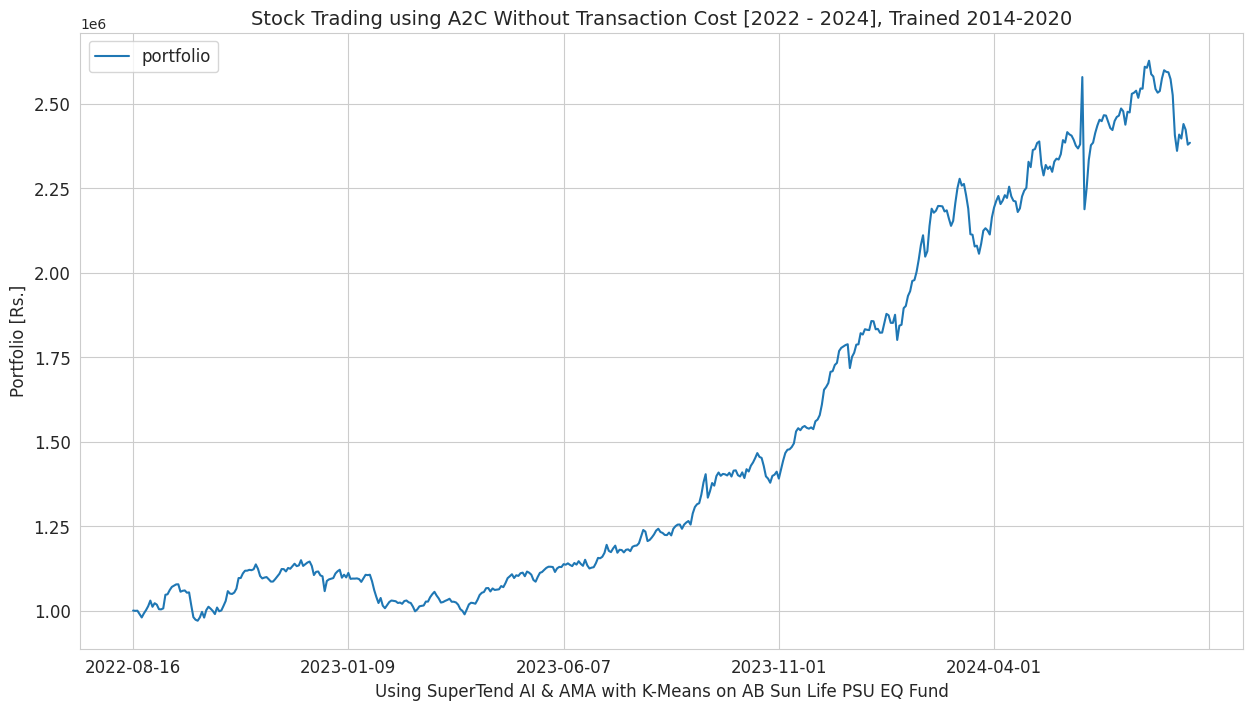

In [11]:
a2c_result_df =  pd.read_csv('/content/trade_0_results.csv')
a2c_result_df = a2c_result_df.set_index('date')

a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Using SuperTend AI & AMA with K-Means on AB Sun Life PSU EQ Fund', fontsize = 12)
plt.ylabel('Portfolio [Rs.]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C Without Transaction Cost [2022 - 2024], Trained 2014-2020', fontsize = 14)
plt.show()

Save the new model if performance is satisfatory

In [18]:
a2c_model.save('/content/drive/MyDrive/Colab Notebooks/AI&ML Models - Stock Trading/A2C_SuperTrendAI_AMA_KMeans_No_Optim_2014_2020_AB-SunLife-PSU-EQ-Fund')

Revaluate if necessary

In [24]:
print('Trading started using the new model on Trading dataset')
print('20 training Episodes for performance evaluation')

for i in range (0,20):                                                             # Trading loop
  trade_return = render_trading(a2c_model, trade_env, trading_data, )

print('Trading Done')

Trading started using the new model on Trading dataset
20 training Episodes for performance evaluation
Writing asset memory to CSV...
Writing transactions to CSV...
Initial Portfolio Value: 1000000 | Final Portfolio Value: 1835381.720981598 | Total rewards: 835381.7209815979 | % of profit: 83.53817209815979
Writing asset memory to CSV...
Writing transactions to CSV...
Initial Portfolio Value: 1000000 | Final Portfolio Value: 1932951.4492607117 | Total rewards: 932951.4492607117 | % of profit: 93.29514492607117
Writing asset memory to CSV...
Writing transactions to CSV...
Initial Portfolio Value: 1000000 | Final Portfolio Value: 1814531.7213363647 | Total rewards: 814531.7213363647 | % of profit: 81.45317213363647
Writing asset memory to CSV...
Writing transactions to CSV...
Initial Portfolio Value: 1000000 | Final Portfolio Value: 1825614.5743274689 | Total rewards: 825614.5743274689 | % of profit: 82.56145743274689
Writing asset memory to CSV...
Writing transactions to CSV...
Initial 

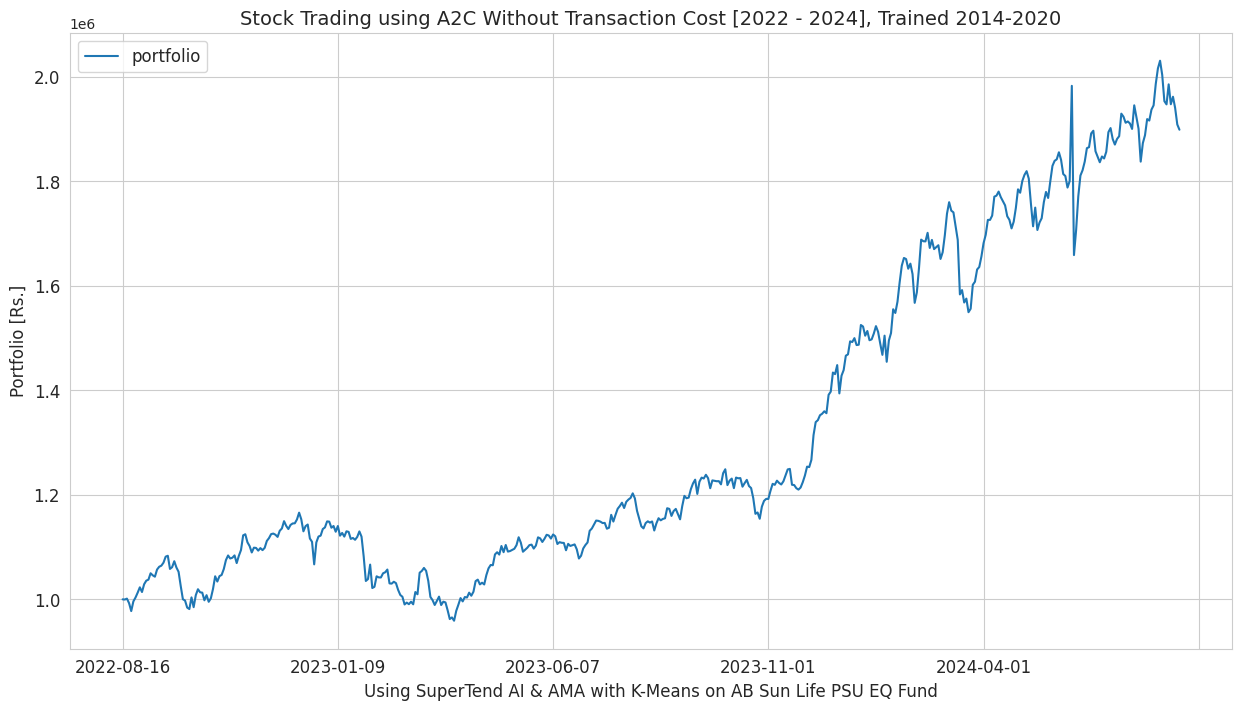

In [23]:
a2c_result_df =  pd.read_csv('/content/trade_0_results.csv')
a2c_result_df = a2c_result_df.set_index('date')

a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Using SuperTend AI & AMA with K-Means on AB Sun Life PSU EQ Fund', fontsize = 12)
plt.ylabel('Portfolio [Rs.]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C Without Transaction Cost [2022 - 2024], Trained 2014-2020', fontsize = 14)
plt.show()